https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erixyz","key":"192e825403d461fd6dd4aab6be96f111"}'}

In [ ]:
#important stuff. always add
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 21.2MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from scipy.stats import trim_mean as tm
import plotly.express as px
from sklearn import linear_model
import random
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [ ]:
stroke = pd.read_csv('/content/stroke-prediction-dataset.zip')
print(stroke.shape)
stroke[:3]

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [ ]:
stroke = stroke.drop(columns = 'id')
stroke.index = range(len(stroke))

In [ ]:
#cleaning the gender column
stroke.gender = [1 if i == 'Male' else 0 for i in stroke.gender] #male is 1, female 0

In [ ]:
#change age from float to int type
stroke.age = [int(round(i)) for i in stroke.age]

In [ ]:
#cleaning residence
stroke.Residence_type = [1 if i == 'Urban' else 0 for i in stroke.Residence_type]

In [ ]:
#cleaning martial status
stroke.ever_married = [1 if i == 'Yes' else 0 for i in stroke.ever_married]

In [ ]:
one_smoke = pd.get_dummies(stroke.smoking_status, drop_first=True)
one_work = pd.get_dummies(stroke.work_type, drop_first=True)
stroke = stroke.join(one_smoke)
stroke = stroke.join(one_work)

stroke = stroke.drop(columns = ['work_type', 'smoking_status'])

In [ ]:
stroke.head(3)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes,Never_worked,Private,Self-employed,children
0,1,67,0,1,1,1,228.69,36.6,1,1,0,0,0,1,0,0
1,0,61,0,0,1,0,202.21,NaN,1,0,1,0,0,0,1,0
2,1,80,0,1,1,0,105.92,32.5,1,0,1,0,0,1,0,0


In [ ]:
stroke.isna().sum() #bmi still missing 201 values.

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
Residence_type         0
avg_glucose_level      0
bmi                  201
stroke                 0
formerly smoked        0
never smoked           0
smokes                 0
Never_worked           0
Private                0
Self-employed          0
children               0
dtype: int64

In [ ]:
had_stroke = stroke[stroke['stroke'] == 1]
no_stroke = stroke[stroke['stroke'] == 0]

In [ ]:
print('mean bmi of patients who had stroke',round(had_stroke.bmi.mean(),2))
print('mean bmi of patients who did not have stroke',round(no_stroke.bmi.mean(),2))

mean bmi of patients who had stroke 30.47
mean bmi of patients who did not have stroke 28.82


<BarContainer object of 2 artists>

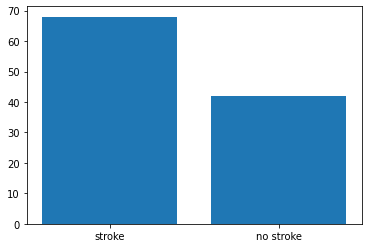

In [ ]:
avg_ages, str_stat = [round(had_stroke.age.mean()),round(no_stroke.age.mean())], ['stroke', 'no stroke']
plt.bar(str_stat, avg_ages)

The following imputes missing values for bmi. Adds variability to the missing predictor val with the use of a normal density. Does not use the values from the smoking status to predict.

In [ ]:
obs_stroke = had_stroke[(had_stroke.bmi.notna())] #complete values for individuals who had a stroke.
miss_stroke = had_stroke[had_stroke.bmi.isna()] #missing values for people who had stroke.
obs_nostroke = no_stroke[no_stroke.bmi.notna()] #complete values for individuals who did not have stroke.
miss_nostroke = no_stroke[no_stroke.bmi.isna()] #missing values for people who did not have a stroke.

param = list(set(obs_stroke.columns) - set(['bmi', 'formerly smoked', 'smokes', 'never smoked', 'stroke']))
model1 = linear_model.LinearRegression()
model1.fit(X = obs_stroke[param], y = obs_stroke['bmi'])

model2 = linear_model.LinearRegression()
model2.fit(X = obs_nostroke[param], y = obs_nostroke['bmi'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred1 = model1.predict(obs_stroke[param])
pred2 = model2.predict(obs_nostroke[param])

std_error1 = (pred1 - obs_stroke.bmi).std()
std_error2 = (pred2 - obs_nostroke.bmi).std()

In [ ]:
random.seed(505)
stoch_val1 = np.round(np.random.normal(size = miss_stroke.shape[0], loc = pred1.mean(), scale = std_error1),1)
random.seed(505)
stoch_val2 = np.round(np.random.normal(size = miss_nostroke.shape[0], loc = pred2.mean(), scale = std_error2),1)

In [ ]:
miss_stroke.bmi = stoch_val1
miss_nostroke.bmi = stoch_val2

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_nomiss = pd.concat([obs_stroke, miss_stroke, obs_nostroke, miss_nostroke], ignore_index=True)

I noticed that there are individuals in this dataframe that have BMI's that are just below 100. In history, the heaviest person ever recorded was 1000 lbs and had a height of 6'1". His BMI was 184.7. These recorded values don't seem too ridiculous LOL.

In [ ]:
stroke = pd.read_csv('/content/stroke-prediction-dataset.zip')
stroke[:3]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [ ]:
df_nomiss['smoking_status'] = stroke.smoking_status
df_nomiss = df_nomiss.drop(columns = ['formerly smoked', 'never smoked', 'smokes'])
df_nomiss[:3]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children,smoking_status
0,1,67,0,1,1,1,228.69,36.6,1,0,1,0,0,formerly smoked
1,1,80,0,1,1,0,105.92,32.5,1,0,1,0,0,never smoked
2,0,49,0,0,1,1,171.23,34.4,1,0,1,0,0,never smoked


In [ ]:
df_nomiss.smoking_status = [np.nan if i == 'Unknown' else i for i in df_nomiss.smoking_status]

In [ ]:
df_nomiss.isna().sum()
df_nomiss.smoking_status.value_counts()

never smoked       1892
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [ ]:
encoder = OrdinalEncoder()
imputer = KNN()
#only contains values which are not null
nonull = np.array(df_nomiss['smoking_status'].dropna())
#reshapes the data for encoding
impute_reshape = nonull.reshape(-1,1)
#encode data
impute_ordinal = encoder.fit_transform(impute_reshape)
#Assign back encoded values to non-null values
df_nomiss['smoking_status'].loc[df_nomiss['smoking_status'].notnull()] = np.squeeze(impute_ordinal)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_nomiss.smoking_status.value_counts()
#0 is formerly smoked
#1 is never smoked
#2 is smokes

1.0    1892
0.0     885
2.0     789
Name: smoking_status, dtype: int64

In [ ]:
final_data = pd.DataFrame(np.round(imputer.fit_transform(df_nomiss)),columns = df_nomiss.columns)

Imputing row 1/5110 with 0 missing, elapsed time: 5.467
Imputing row 101/5110 with 1 missing, elapsed time: 5.470
Imputing row 201/5110 with 1 missing, elapsed time: 5.472
Imputing row 301/5110 with 1 missing, elapsed time: 5.475
Imputing row 401/5110 with 1 missing, elapsed time: 5.477
Imputing row 501/5110 with 0 missing, elapsed time: 5.480
Imputing row 601/5110 with 0 missing, elapsed time: 5.484
Imputing row 701/5110 with 0 missing, elapsed time: 5.487
Imputing row 801/5110 with 0 missing, elapsed time: 5.490
Imputing row 901/5110 with 0 missing, elapsed time: 5.494
Imputing row 1001/5110 with 0 missing, elapsed time: 5.497
Imputing row 1101/5110 with 0 missing, elapsed time: 5.500
Imputing row 1201/5110 with 1 missing, elapsed time: 5.502
Imputing row 1301/5110 with 1 missing, elapsed time: 5.505
Imputing row 1401/5110 with 0 missing, elapsed time: 5.507
Imputing row 1501/5110 with 0 missing, elapsed time: 5.510
Imputing row 1601/5110 with 1 missing, elapsed time: 5.512
Imputing 

In [ ]:
final_data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
avg_glucose_level    0
bmi                  0
stroke               0
Never_worked         0
Private              0
Self-employed        0
children             0
smoking_status       0
dtype: int64

In [ ]:
final_data[:6]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children,smoking_status
0,1.0,67.0,0.0,1.0,1.0,1.0,229.0,37.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,80.0,0.0,1.0,1.0,0.0,106.0,32.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,49.0,0.0,0.0,1.0,1.0,171.0,34.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,79.0,1.0,0.0,1.0,0.0,174.0,24.0,1.0,0.0,0.0,1.0,0.0,2.0
4,1.0,81.0,0.0,0.0,1.0,1.0,186.0,29.0,1.0,0.0,1.0,0.0,0.0,1.0
5,1.0,74.0,1.0,1.0,1.0,0.0,70.0,27.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
final_data = final_data.drop(columns = ['Never_worked', 'Private', 'Self-employed', 'children'])
final_data['work_type'] = stroke.work_type
final_data['age'] = [round(i) for i in final_data['age']]

In [ ]:
final_data[:3]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status,work_type
0,1.0,67,0.0,1.0,1.0,1.0,229.0,37.0,1.0,0.0,Private
1,1.0,80,0.0,1.0,1.0,0.0,106.0,32.0,1.0,1.0,Self-employed
2,0.0,49,0.0,0.0,1.0,1.0,171.0,34.0,1.0,1.0,Private


In [ ]:
smoke_strings = []
for i in final_data.smoking_status:
  if i == 0:
    smoke_strings.append('formerly smoked')
  if i == 1:
    smoke_strings.append('never smoked')
  if i == 2:
    smoke_strings.append('smokes')
final_data['smoking_status'] = smoke_strings

In [ ]:
final_data[:6]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status,work_type
0,1.0,67,0.0,1.0,1.0,1.0,229.0,37.0,1.0,formerly smoked,Private
1,1.0,80,0.0,1.0,1.0,0.0,106.0,32.0,1.0,never smoked,Self-employed
2,0.0,49,0.0,0.0,1.0,1.0,171.0,34.0,1.0,never smoked,Private
3,0.0,79,1.0,0.0,1.0,0.0,174.0,24.0,1.0,smokes,Private
4,1.0,81,0.0,0.0,1.0,1.0,186.0,29.0,1.0,never smoked,Self-employed
5,1.0,74,1.0,1.0,1.0,0.0,70.0,27.0,1.0,formerly smoked,Private


In [ ]:
fin_stroke = final_data[final_data['stroke'] == 1]
fin_nostroke = final_data[final_data['stroke'] == 0]

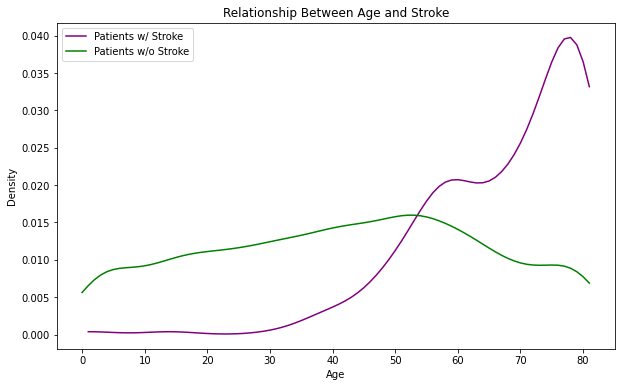

In [ ]:
stroke_age_density = stats.kde.gaussian_kde(fin_stroke.age)
x_int1 = np.arange(min(fin_stroke.age), max(fin_stroke.age), 1)
nostroke_age_density = stats.kde.gaussian_kde(fin_nostroke.age)
x_int2 = np.arange(min(fin_nostroke.age), max(fin_nostroke.age), 1)

plt.figure(figsize=(10,6))
plt.plot(x_int1, stroke_age_density(x_int1), c = 'purple', label = 'Patients w/ Stroke')
plt.plot(x_int2, nostroke_age_density(x_int2), c = 'green', label = 'Patients w/o Stroke')
plt.title('Relationship Between Age and Stroke')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show();

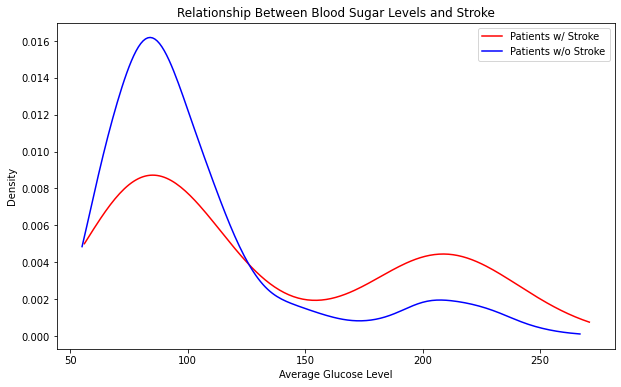

In [ ]:
stroke_glucose_density = stats.kde.gaussian_kde(fin_stroke.avg_glucose_level)
x_int3 = np.arange(min(fin_stroke.avg_glucose_level), max(fin_stroke.avg_glucose_level), 1)
nostroke_glucose_density = stats.kde.gaussian_kde(fin_nostroke.avg_glucose_level)
x_int4 = np.arange(min(fin_nostroke.avg_glucose_level), max(fin_nostroke.avg_glucose_level), 1)

plt.figure(figsize=(10,6))
plt.plot(x_int3, stroke_glucose_density(x_int3), c = 'red', label = 'Patients w/ Stroke')
plt.plot(x_int4, nostroke_glucose_density(x_int4), c = 'blue', label = 'Patients w/o Stroke')
plt.title('Relationship Between Blood Sugar Levels and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Density')
plt.legend()
plt.show();

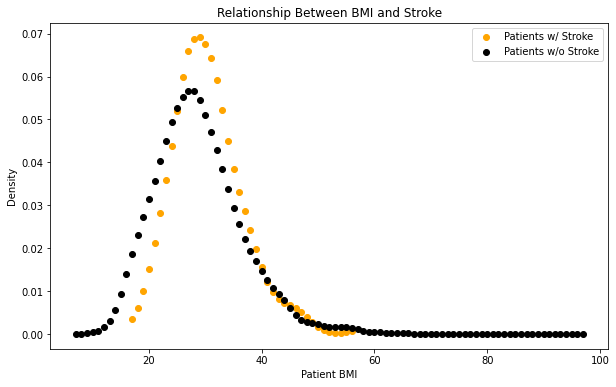

In [ ]:
stroke_bmi_density = stats.kde.gaussian_kde(fin_stroke.bmi)
x_int5 = np.arange(min(fin_stroke.bmi), max(fin_stroke.bmi), 1)
nostroke_bmi_density = stats.kde.gaussian_kde(fin_nostroke.bmi)
x_int6 = np.arange(min(fin_nostroke.bmi), max(fin_nostroke.bmi), 1)

plt.figure(figsize=(10,6))
plt.scatter(x_int5, stroke_bmi_density(x_int5), c = 'orange', label = 'Patients w/ Stroke')
plt.scatter(x_int6, nostroke_bmi_density(x_int6), c = 'black', label = 'Patients w/o Stroke')
plt.title('Relationship Between BMI and Stroke')
plt.xlabel('Patient BMI')
plt.ylabel('Density')
plt.legend()
plt.show();

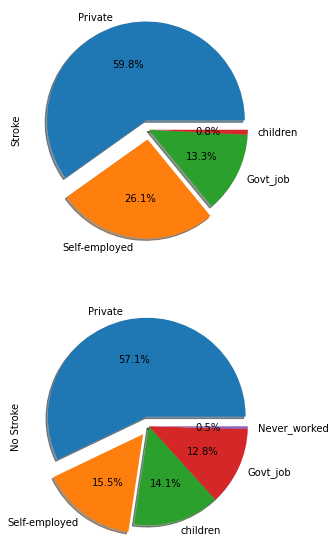

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (14,10))
fin_stroke.work_type.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[0], explode = (0.1,0.1,0,0), shadow = True, label = 'Stroke')
fin_nostroke.work_type.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[1], explode = (0.1,0.1,0,0,0), shadow =  True, label = 'No Stroke');

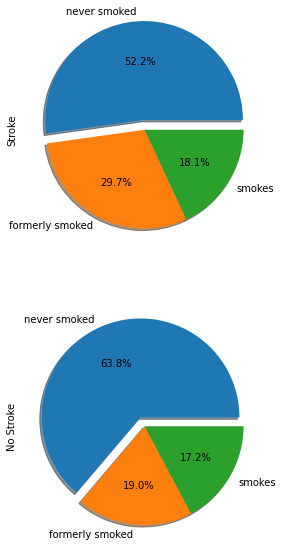

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (14,10))
fin_stroke.smoking_status.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[0], explode = (0.1,0,0), shadow = True, label = 'Stroke')
fin_nostroke.smoking_status.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[1], explode = (0.1,0,0), shadow = True, label = 'No Stroke');

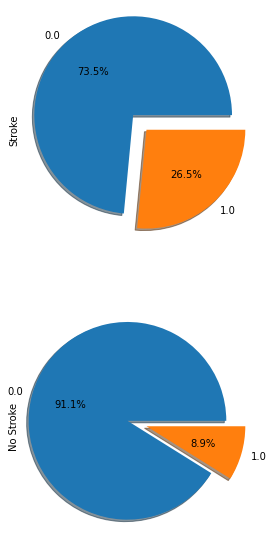

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (14,10))
fin_stroke.hypertension.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[0], shadow = True, label = 'Stroke', explode = (0.2,0))
fin_nostroke.hypertension.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[1], shadow = True, label = 'No Stroke', explode = (0.2,0));

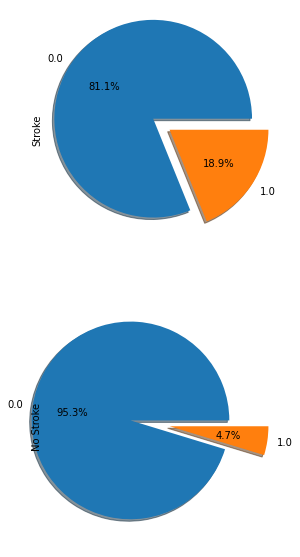

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (14,10))
fin_stroke.heart_disease.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[0], shadow = True, label = 'Stroke', explode = (0.2, 0))
fin_nostroke.heart_disease.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', ax = axs[1], shadow = True, label = 'No Stroke', explode = (0.4, 0));

In [ ]:
tab1 = pd.crosstab(final_data.stroke, final_data.gender)
tab1

gender,0.0,1.0
stroke,,
0.0,2854,2007
1.0,141,108


In [ ]:
OR, pval = stats.fisher_exact(tab1)
print('The odds ratio is',OR,'. While the p-value is',pval)

The odds ratio is 1.0892090449384602 . While the p-value is 0.5104574776018146


In [ ]:
seOR = np.sqrt(1/2854+1/141+1/2007+1/108)
confint = 1.96
print('(',np.exp(np.log(OR)-seOR*confint),',', np.exp(np.log(OR)+seOR*confint),')')

( 0.8423155717205929 , 1.4084701546622826 )


There is little evidence to suggest that gender and the event of having a stroke are categories that are dependent on one another.

In [ ]:
final_data.to_csv(r'/content/imputed_stroke.csv', index = False)